# **SETUP**

In [11]:
from keras.models import Sequential
from keras.layers import Dense, LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import numpy.ma as ma
scaler_input = StandardScaler()
scaler_output = StandardScaler()
import os

# **LOADING DATA**

In [12]:

SteadyState_Input = []

base_path = r'C:\\Users\\ismai\\OneDrive\\Desktop\\CFD Dissertation\\Files\\CSV training\\SteadyCSV'

transient_base_path = r'C:\\Users\\ismai\\OneDrive\\Desktop\\CFD Dissertation\\Files\\CSV training\\ML_OutputLowMaxSS_CSV'

Transient_Output = []

for i in range(1, 41):  # Loop from N1 to N40
    # Construct the steady state file path
    steady_folder_name = f"N{i}Steady"
    steady_file_name = f"N{i}SSS.csv"
    steady_file_path = os.path.join(base_path, steady_folder_name, steady_file_name)
    
    # Construct the transient file path (assuming a similar naming convention)
    transient_folder_name = f"N{i}"
    transient_file_name = f"N{i}TS2.csv"
    transient_file_path = os.path.join(transient_base_path, transient_folder_name, transient_file_name)

      
    NP = pd.read_csv(steady_file_path)
    NP = NP.replace(' null', 0)
    NPSteady_velocity = NP.iloc[:, 4].values.reshape(-1, 1)
    NPSteady_velocity = scaler_input.fit_transform(NPSteady_velocity)
    SteadyState_Input.append(NPSteady_velocity)

    # Process the transient CSV
    NT = pd.read_csv(transient_file_path)
    NT = NT.replace(' null', 0)
    NPTransient_velocity = NT.iloc[:, 4].values.reshape(-1, 1)
    NPTransient_velocity = scaler_output.fit_transform(NPTransient_velocity)
    Transient_Output.append(NPTransient_velocity)

# **DENSE**

In [51]:
from keras.optimizers import Adam
# Initialize the model
model = Sequential()

SteadyState_Input_Dense = np.concatenate(SteadyState_Input)
Transient_Output_Dense = np.concatenate(Transient_Output)

# Split the data into training and testing sets
Steady_train, Steady_test, Transient_train, Transient_test = train_test_split(SteadyState_Input_Dense, Transient_Output_Dense, test_size=0.2, random_state=42)

model.add(Dense(32, input_dim=1, activation='relu'))

# Add hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Add output layer
model.add(Dense(1))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam())

# Fit the model
model.fit(Steady_train, Transient_train, epochs=5, batch_size=128, validation_split=0.4)
# Make predictions
predictions = model.predict(Steady_test)
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mse'])
loss, mse = model.evaluate(Steady_test, Transient_test)
print(f"Model performance:\nLoss: {loss}\nMSE: {mse}")

Epoch 1/5
1001/1001 [==============================] - 2s 2ms/step - loss: 0.0558 - val_loss: 0.0430
Epoch 2/5
1001/1001 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.0429
Epoch 3/5
1001/1001 [==============================] - 2s 2ms/step - loss: 0.0448 - val_loss: 0.0430
Epoch 4/5
1001/1001 [==============================] - 2s 2ms/step - loss: 0.0445 - val_loss: 0.0424
Epoch 5/5
1669/1669 [==============================] - 2s 996us/step - loss: 0.0431 - mse: 0.0431
Model performance:
Loss: 0.043085694313049316
MSE: 0.043085694313049316


In [14]:
from keras.optimizers import Adam
# Preprocess the data
SteadyState_Input_Dense = np.concatenate(SteadyState_Input)
Transient_Output_Dense = np.concatenate(Transient_Output)

# Split the data into training and testing sets
Steady_train, Steady_test, Transient_train, Transient_test = train_test_split(SteadyState_Input_Dense, Transient_Output_Dense, test_size=0.2, random_state=42)

# Determine the number of input features
num_input_features = Steady_train.shape[1]

# Initialize the model
model = Sequential()

# Add input layer with neurons equal to the number of input features
model.add(Dense(num_input_features, input_dim=num_input_features, activation='relu'))

# Add hidden layers
model.add(Dense(64, activation='relu'))
model.add(Dense(64, activation='relu'))

# Determine the number of outputs and add output layer
num_outputs = Transient_train.shape[1] if len(Transient_train.shape) > 1 else 1
model.add(Dense(num_outputs))

# Compile the model
model.compile(loss='mean_squared_error', optimizer=Adam(), metrics=['mse'])

# Fit the model
model.fit(Steady_train, Transient_train, epochs=5, batch_size=16, validation_split=0.4)

# Evaluate the model
loss, mse = model.evaluate(Steady_test, Transient_test)
print(f"Model performance:\nLoss: {loss}\nMSE: {mse}")

Epoch 1/5


8007/8007 [==============================] - 13s 2ms/step - loss: 0.0506 - mse: 0.0506 - val_loss: 0.0432 - val_mse: 0.0432
Epoch 2/5
8007/8007 [==============================] - 11s 1ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0427 - val_mse: 0.0427
Epoch 3/5
8007/8007 [==============================] - 13s 2ms/step - loss: 0.0454 - mse: 0.0454 - val_loss: 0.0450 - val_mse: 0.0450
Epoch 4/5
8007/8007 [==============================] - 12s 1ms/step - loss: 0.0452 - mse: 0.0452 - val_loss: 0.0431 - val_mse: 0.0431
Epoch 5/5
1669/1669 [==============================] - 1s 768us/step - loss: 0.0439 - mse: 0.0439
Model performance:
Loss: 0.043891873210668564
MSE: 0.043891873210668564


# **PREDICTION**

In [15]:
# https://keras.io/api/models/model_training_apis/
SteadyState_New0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N0\N0SSS.csv')
SteadyState_New1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N41\N41SSS.csv')
SteadyState_New2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N42\N42SSS.csv')
SteadyState_New3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N43\N43SSS.csv')
SteadyState_New4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N44\N44SSS.csv')
SteadyState_New5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N45\N45SSS.csv')
SteadyState_New6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N46\N46SSS.csv')
SteadyState_New7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N47\N47SSS.csv')
SteadyState_New8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N48\N48SSS.csv')
SteadyState_New9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N49\N49SSS.csv')
SteadyState_New0 = SteadyState_New0.replace(' null', 0)
SteadyState_New1 = SteadyState_New1.replace(' null', 0)
SteadyState_New2 = SteadyState_New2.replace(' null', 0)
SteadyState_New3 = SteadyState_New3.replace(' null', 0)
SteadyState_New4 = SteadyState_New4.replace(' null', 0)
SteadyState_New5 = SteadyState_New5.replace(' null', 0)
SteadyState_New6 = SteadyState_New6.replace(' null', 0)
SteadyState_New7 = SteadyState_New7.replace(' null', 0)
SteadyState_New8 = SteadyState_New8.replace(' null', 0)
SteadyState_New9 = SteadyState_New9.replace(' null', 0)
SteadyStateVelocity_0 = SteadyState_New0.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_1 = SteadyState_New1.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_2 = SteadyState_New2.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_3 = SteadyState_New3.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_4 = SteadyState_New4.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_5 = SteadyState_New5.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_6 = SteadyState_New6.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_7 = SteadyState_New7.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_8 = SteadyState_New8.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_9 = SteadyState_New9.iloc[:, 4].values.reshape(-1, 1)
SteadyStateVelocity_0 = scaler_input.transform(SteadyStateVelocity_0 )
SteadyStateVelocity_1 = scaler_input.transform(SteadyStateVelocity_1 )
SteadyStateVelocity_2 = scaler_input.transform(SteadyStateVelocity_2 )
SteadyStateVelocity_3 = scaler_input.transform(SteadyStateVelocity_3 )
SteadyStateVelocity_4 = scaler_input.transform(SteadyStateVelocity_4 )
SteadyStateVelocity_5 = scaler_input.transform(SteadyStateVelocity_5 )
SteadyStateVelocity_6 = scaler_input.transform(SteadyStateVelocity_6 )
SteadyStateVelocity_7 = scaler_input.transform(SteadyStateVelocity_7 )
SteadyStateVelocity_8 = scaler_input.transform(SteadyStateVelocity_8 )
SteadyStateVelocity_9 = scaler_input.transform(SteadyStateVelocity_9 )
SteadyStateVelocity_0 = SteadyStateVelocity_0.reshape((SteadyStateVelocity_0.shape[0], 1, SteadyStateVelocity_0.shape[1]))
SteadyStateVelocity_1 = SteadyStateVelocity_1.reshape((SteadyStateVelocity_1.shape[0], 1, SteadyStateVelocity_1.shape[1]))
SteadyStateVelocity_2 = SteadyStateVelocity_2.reshape((SteadyStateVelocity_2.shape[0], 1, SteadyStateVelocity_2.shape[1]))
SteadyStateVelocity_3 = SteadyStateVelocity_3.reshape((SteadyStateVelocity_3.shape[0], 1, SteadyStateVelocity_3.shape[1]))
SteadyStateVelocity_4 = SteadyStateVelocity_4.reshape((SteadyStateVelocity_4.shape[0], 1, SteadyStateVelocity_4.shape[1]))
SteadyStateVelocity_5 = SteadyStateVelocity_5.reshape((SteadyStateVelocity_5.shape[0], 1, SteadyStateVelocity_5.shape[1]))
SteadyStateVelocity_6 = SteadyStateVelocity_6.reshape((SteadyStateVelocity_6.shape[0], 1, SteadyStateVelocity_6.shape[1]))
SteadyStateVelocity_7 = SteadyStateVelocity_7.reshape((SteadyStateVelocity_7.shape[0], 1, SteadyStateVelocity_7.shape[1]))
SteadyStateVelocity_8 = SteadyStateVelocity_8.reshape((SteadyStateVelocity_8.shape[0], 1, SteadyStateVelocity_8.shape[1]))
SteadyStateVelocity_9 = SteadyStateVelocity_9.reshape((SteadyStateVelocity_9.shape[0], 1, SteadyStateVelocity_9.shape[1]))
Prediction0 = model.predict(SteadyStateVelocity_0)
Prediction1 = model.predict(SteadyStateVelocity_1)
Prediction2 = model.predict(SteadyStateVelocity_2)
Prediction3 = model.predict(SteadyStateVelocity_3)
Prediction4 = model.predict(SteadyStateVelocity_4)
Prediction5 = model.predict(SteadyStateVelocity_5)
Prediction6 = model.predict(SteadyStateVelocity_6)
Prediction7 = model.predict(SteadyStateVelocity_7)
Prediction8 = model.predict(SteadyStateVelocity_8)
Prediction9 = model.predict(SteadyStateVelocity_9)
Prediction0 = scaler_output.inverse_transform(Prediction0)
Prediction1 = scaler_output.inverse_transform(Prediction1)
Prediction2 = scaler_output.inverse_transform(Prediction2)
Prediction3 = scaler_output.inverse_transform(Prediction3)
Prediction4 = scaler_output.inverse_transform(Prediction4)
Prediction5 = scaler_output.inverse_transform(Prediction5)
Prediction6 = scaler_output.inverse_transform(Prediction6)
Prediction7 = scaler_output.inverse_transform(Prediction7)
Prediction8 = scaler_output.inverse_transform(Prediction8)
Prediction9 = scaler_output.inverse_transform(Prediction9)
SteadyState_New0 ['Transient Prediction 0'] = Prediction0
SteadyState_New1 ['Transient Prediction 1'] = Prediction1
SteadyState_New2 ['Transient Prediction 2'] = Prediction2
SteadyState_New3 ['Transient Prediction 3'] = Prediction3
SteadyState_New4 ['Transient Prediction 4'] = Prediction4
SteadyState_New5 ['Transient Prediction 5'] = Prediction5
SteadyState_New6 ['Transient Prediction 6'] = Prediction6
SteadyState_New7 ['Transient Prediction 7'] = Prediction7
SteadyState_New8 ['Transient Prediction 8'] = Prediction8
SteadyState_New9 ['Transient Prediction 9'] = Prediction9
print(Prediction0)
print(Prediction1)
print(Prediction2)
print(Prediction3)
print(Prediction4)
print(Prediction5)
print(Prediction6)
print(Prediction7)
print(Prediction8)
print(Prediction9)
SteadyState_New0.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N0DS.csv', index=False)
SteadyState_New1.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N41DS.csv', index=False)
SteadyState_New2.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N42DS.csv', index=False)
SteadyState_New3.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N43DS.csv', index=False)
SteadyState_New4.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N44DS.csv', index=False)
SteadyState_New5.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N45DS.csv', index=False)
SteadyState_New6.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N46DS.csv', index=False)
SteadyState_New7.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N47DS.csv', index=False)
SteadyState_New8.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N48DS.csv', index=False)
SteadyState_New9.to_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N49DS.csv', index=False)

30/30 [==============================] - 0s 714us/step
[[0.11249018]
 [0.10946813]
 [0.10864398]
 ...
 [0.23879656]
 [0.08062151]
 [0.22782746]]
[[2.6132433 ]
 [2.4435809 ]
 [2.1803112 ]
 [0.80546737]
 [0.5451815 ]
 [0.68955797]
 [2.2544165 ]
 [2.390927  ]
 [2.6327448 ]
 [1.5186143 ]
 [1.1531959 ]
 [0.96595746]
 [1.7629803 ]
 [1.9170419 ]
 [2.2232144 ]
 [2.5157359 ]
 [2.4767332 ]
 [2.593742  ]
 [2.7719939 ]
 [2.732014  ]
 [2.0223496 ]
 [2.5547388 ]
 [0.58825374]
 [0.4221181 ]
 [0.5328751 ]
 [0.50826246]
 [2.5352378 ]
 [2.338273  ]
 [2.5742402 ]
 [1.4311012 ]
 [1.1829162 ]
 [1.3387547 ]
 [0.98973376]
 [0.9778456 ]
 [1.3361996 ]
 [1.4727849 ]
 [0.69550204]
 [0.6436322 ]
 [1.9131415 ]
 [1.7668808 ]
 [2.1647103 ]
 [0.72225034]
 [0.84113187]
 [2.2544165 ]
 [2.4123783 ]
 [0.41904145]
 [0.86193615]
 [1.0016217 ]
 [2.4416306 ]
 [1.0462024 ]
 [1.1205033 ]
 [1.2066925 ]
 [0.81141144]
 [0.91543275]
 [1.176972  ]
 [1.5340183 ]
 [1.0670067 ]
 [1.248301  ]
 [0.62209606]
 [2.1705606 ]
 [2.6920342 ]
 

# **RESULT N0**

In [16]:
PredictedTransient0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N0DS.csv')
# Print column names
print(PredictedTransient0.columns)
PredictedTransient0 = PredictedTransient0.fillna(0)
PredictedTransient0 = PredictedTransient0.replace(' null', np.nan)
x = PredictedTransient0[' X [ m ]']
y = PredictedTransient0[' Y [ m ]']
ste_velocity = PredictedTransient0[' Wall Shear [ Pa ]']
velocity = PredictedTransient0['Transient Prediction 0']
diff_ste = PredictedTransient0['Transient Prediction 0'] - PredictedTransient0[' Wall Shear [ Pa ]']
CFDTransient0 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N0tlow\N0TS2.csv')
print(CFDTransient0.columns)
CFDTransient0 = CFDTransient0.fillna(0)
CFDTransient0 = CFDTransient0.replace(' null', np.nan)
x = CFDTransient0 [' X [ m ]']
y = CFDTransient0 [' Y [ m ]']
velocity_truth = CFDTransient0 [' Wall Shear [ Pa ]']
diff_vel = PredictedTransient0['Transient Prediction 0'] - CFDTransient0[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 0'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


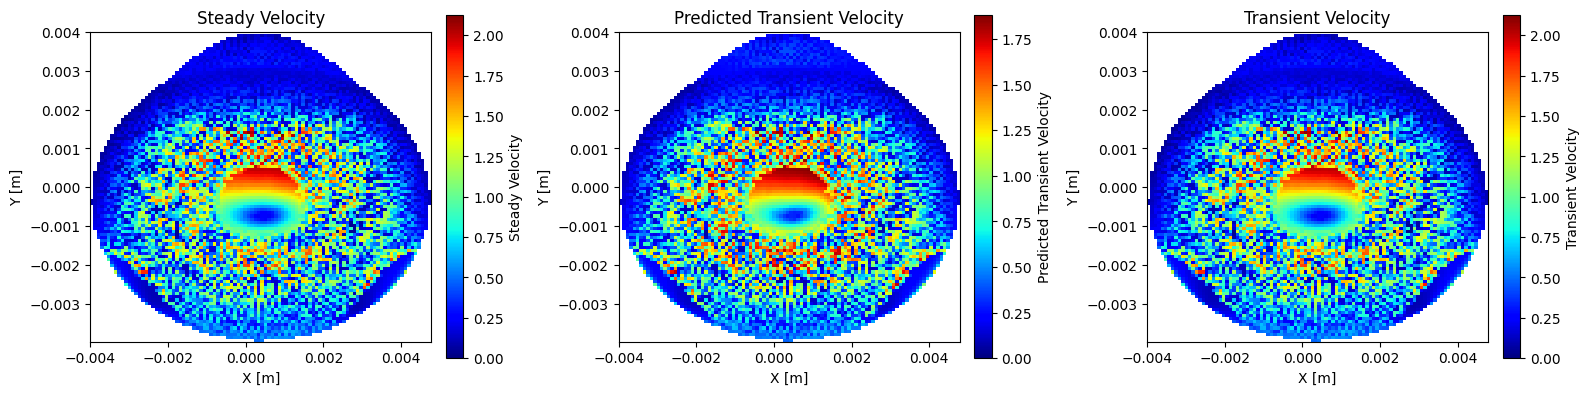

In [17]:
# Generate your grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j] #Interpolation of data onto a grid:

# Interpolate the velocity onto the grid
grid_velocity0 = griddata((x, y), ste_velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Create a colormap
cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values
# masked array where 'nan' values, 0 velocity values, and velocity values 0.001 or less are masked


masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Generate heat maps for velocity
#plt.subplot(1, 1, 1)
fig, (ax0,ax1,ax2) = plt.subplots(1,3,figsize=(16, 26))
fig.patch.set_facecolor('white')
rotated_masked_velocity0 = np.rot90(masked_velocity2, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)

# Plot the rotated data
im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity0.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity', fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity1.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity', fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

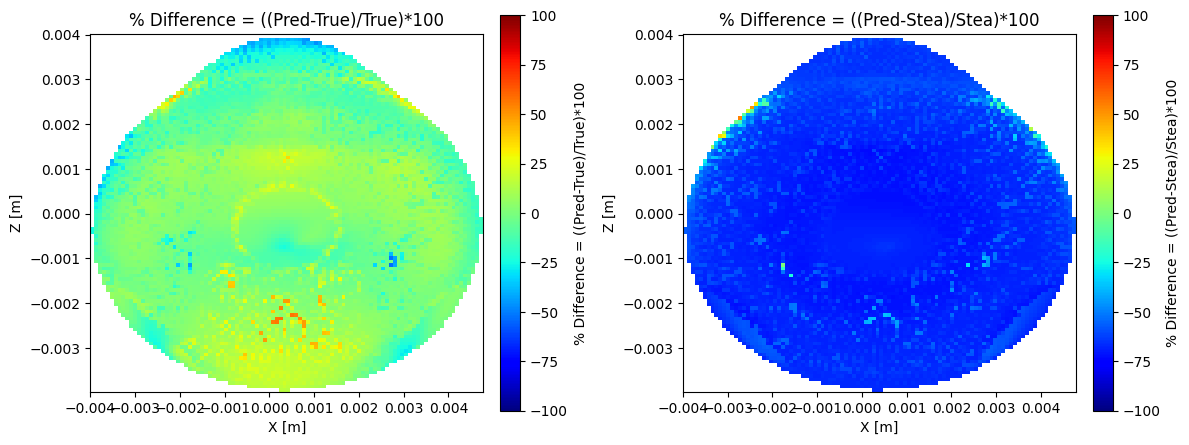

<Figure size 640x480 with 0 Axes>

In [18]:
# Calculate percentage differences
percentage_change3 = ((masked_velocity2 - masked_velocity1) / masked_velocity1) * 100
percentage_change4 = ((masked_velocity1 - masked_velocity0) / masked_velocity0) * 100


rotated_percentage_change3 = np.rot90(percentage_change3, 1)
rotated_percentage_change4 = np.rot90(percentage_change4, 1)

fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

# Heatmap for percentage difference between predicted transient and transient truth
im3 = ax3.imshow(rotated_percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

# Heatmap for percentage difference between predicted transient and steady velocity
im4 = ax4.imshow(rotated_percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()

plt.tight_layout()
plt.show()

In [20]:
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

print(average_percentage_change3/100, average_percentage_change4)

max_shear = np.max(Prediction0)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient0[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction0)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient0[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient0[' Wall Shear [ Pa ]'], Prediction0)
print(r2)

0.08163148189128604 65.58791770324407
Maximum shear from the prediction is: 2.0028481483459473
Maximum shear from the actual is: 2.31
Min shear from the prediction is: 0.046598825603723526
Min shear from the actual is: 0.00516
% is: 13.2966169547209
0.9889099576202631


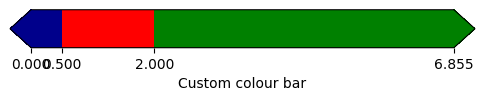

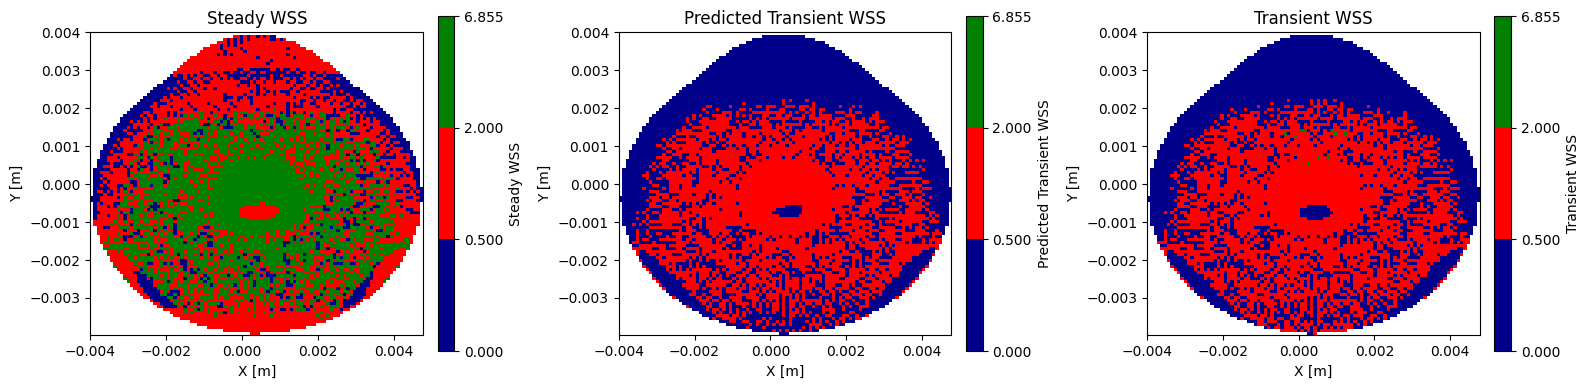

In [21]:
import matplotlib as mpl
# Generate your grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolate the velocity onto the grid
grid_WSS0 = griddata((x, y), ste_velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste, (grid_x, grid_y), method='linear', fill_value=np.nan)

max_value = np.nanmax([grid_WSS0])

colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)
#cmap = plt.cm.jet  # or any other colormap
cmap.set_bad(color='white')  # set color for 'nan' values

# Rotate the data
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)
rotated_masked_WSS3 = np.rot90(masked_WSS3, 1)
rotated_masked_WSS4 = np.rot90(masked_WSS4, 1)

# Generate heat maps for velocity
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")
plt.tight_layout()
plt.show()

# **RESULT N41**

In [22]:
PredictedTransient1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N41DS.csv')
# Print column names
print(PredictedTransient1.columns)
PredictedTransient1 = PredictedTransient1.fillna(0)
PredictedTransient1 = PredictedTransient1.replace(' null', np.nan)
x = PredictedTransient1[' X [ m ]']
y = PredictedTransient1[' Y [ m ]']
ste_velocity1 = PredictedTransient1[' Wall Shear [ Pa ]']
velocity1 = PredictedTransient1['Transient Prediction 1']
diff_ste1 = PredictedTransient1['Transient Prediction 1'] - PredictedTransient1[' Wall Shear [ Pa ]']
CFDTransient1 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N41Tlow\N41TS2.csv')
print(CFDTransient1.columns)
CFDTransient1 = CFDTransient1.fillna(0)
CFDTransient1 = CFDTransient1.replace(' null', np.nan)
x = CFDTransient1 [' X [ m ]']
y = CFDTransient1 [' Y [ m ]']
velocity_truth1 = CFDTransient1 [' Wall Shear [ Pa ]']
diff_vel1 = PredictedTransient1['Transient Prediction 1'] - CFDTransient1[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 1'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


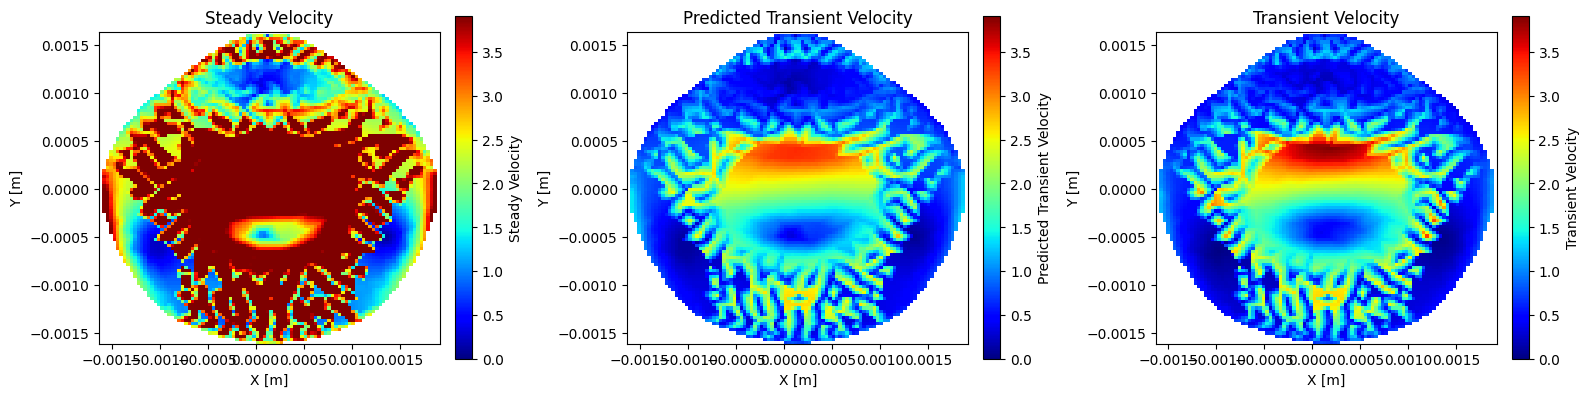

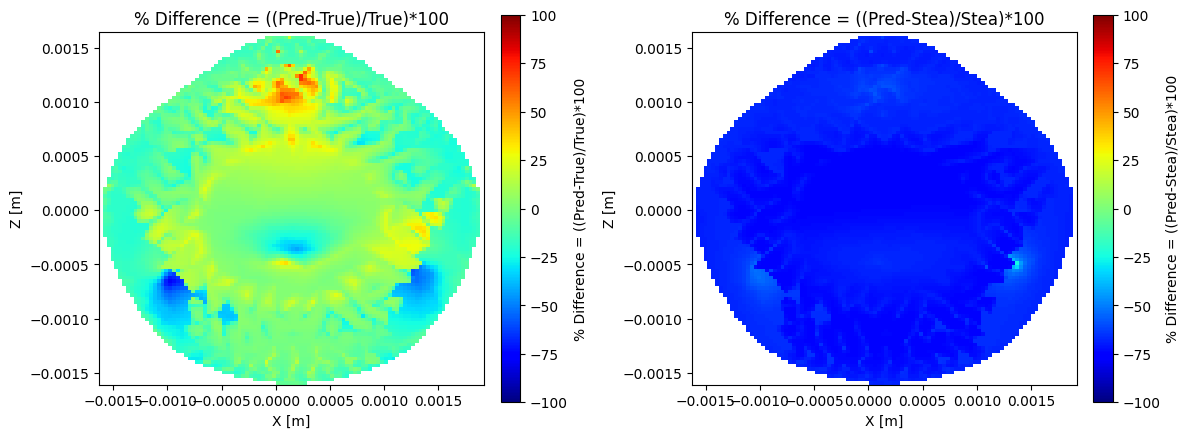

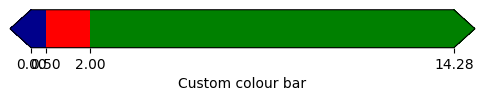

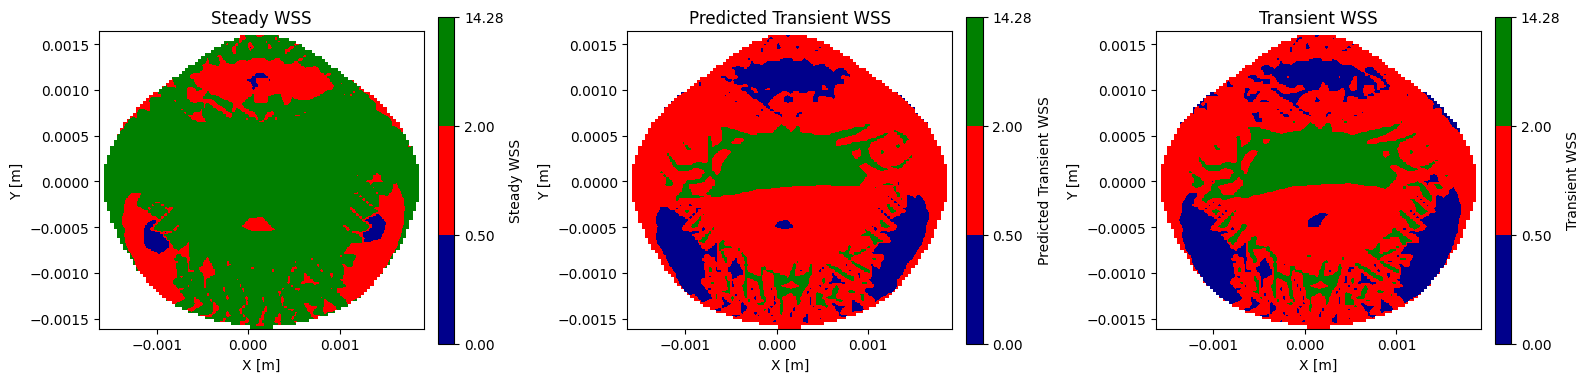

In [23]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste1, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel1, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste1, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

In [24]:
max_shear = np.max(Prediction1)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient1[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction1)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient1[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient1[' Wall Shear [ Pa ]'], Prediction1)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3/100, average_percentage_change4

Maximum shear from the prediction is: 3.381493330001831
Maximum shear from the actual is: 3.94
Min shear from the prediction is: 0.06276401877403259
Min shear from the actual is: 0.0197
% is: 14.175296192846925
0.9594405147201954


(0.12385399330249637, 70.23335954806272)

# **RESULT N42**

In [25]:
PredictedTransient2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N42DS.csv')
# Print column names
print(PredictedTransient2.columns)
PredictedTransient2 = PredictedTransient2.fillna(0)
PredictedTransient2 = PredictedTransient2.replace(' null', np.nan)
x = PredictedTransient2[' X [ m ]']
y = PredictedTransient2[' Y [ m ]']
ste_velocity2 = PredictedTransient2[' Wall Shear [ Pa ]']
velocity2 = PredictedTransient2['Transient Prediction 2']
diff_ste2 = PredictedTransient2['Transient Prediction 2'] - PredictedTransient2[' Wall Shear [ Pa ]']
CFDTransient2 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N42Tlow\N42TS2.csv')
print(CFDTransient2.columns)
CFDTransient2 = CFDTransient2.fillna(0)
CFDTransient2 = CFDTransient2.replace(' null', np.nan)
x = CFDTransient2 [' X [ m ]']
y = CFDTransient2 [' Y [ m ]']
velocity_truth2 = CFDTransient2 [' Wall Shear [ Pa ]']
diff_vel2 = PredictedTransient2['Transient Prediction 2'] - CFDTransient2[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 2'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


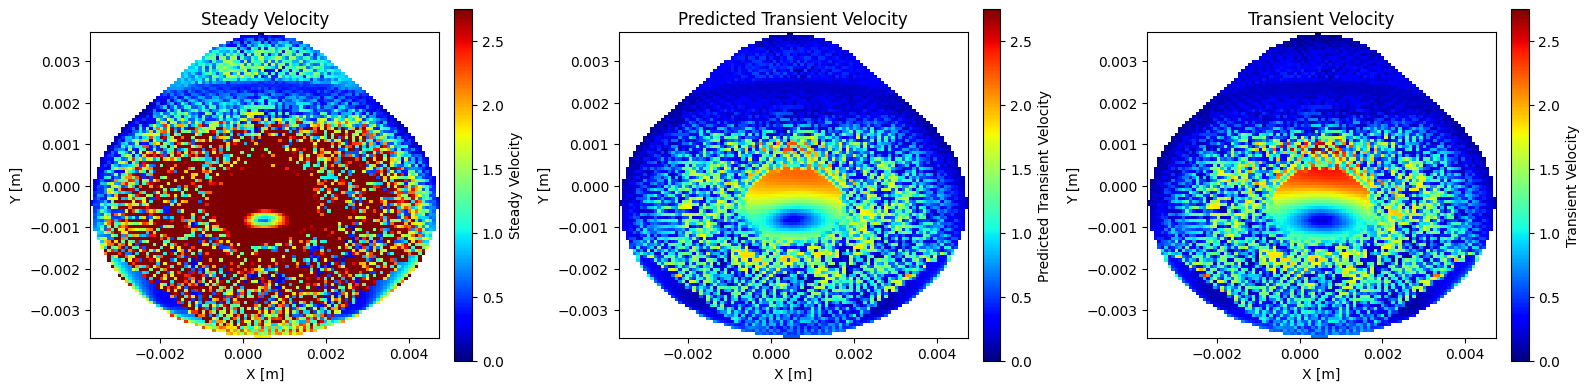

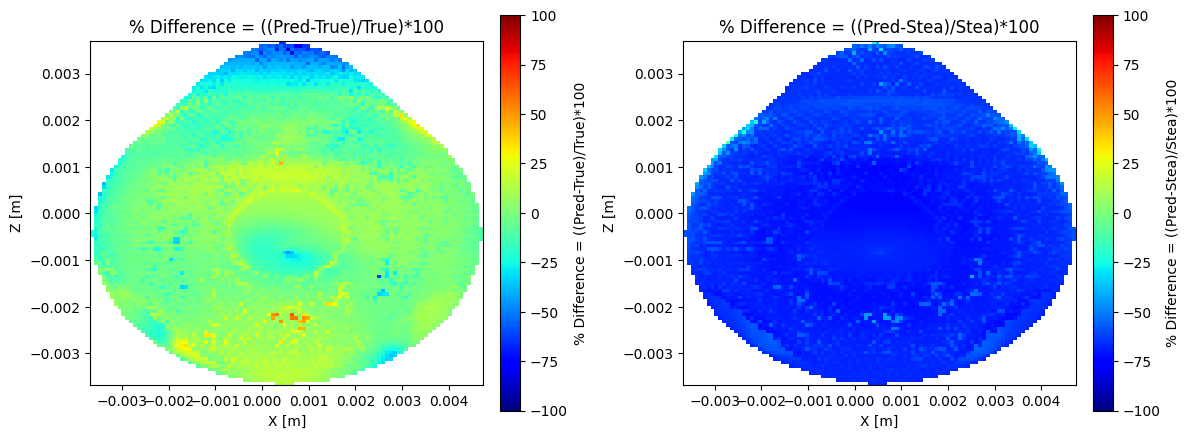

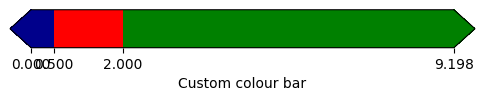

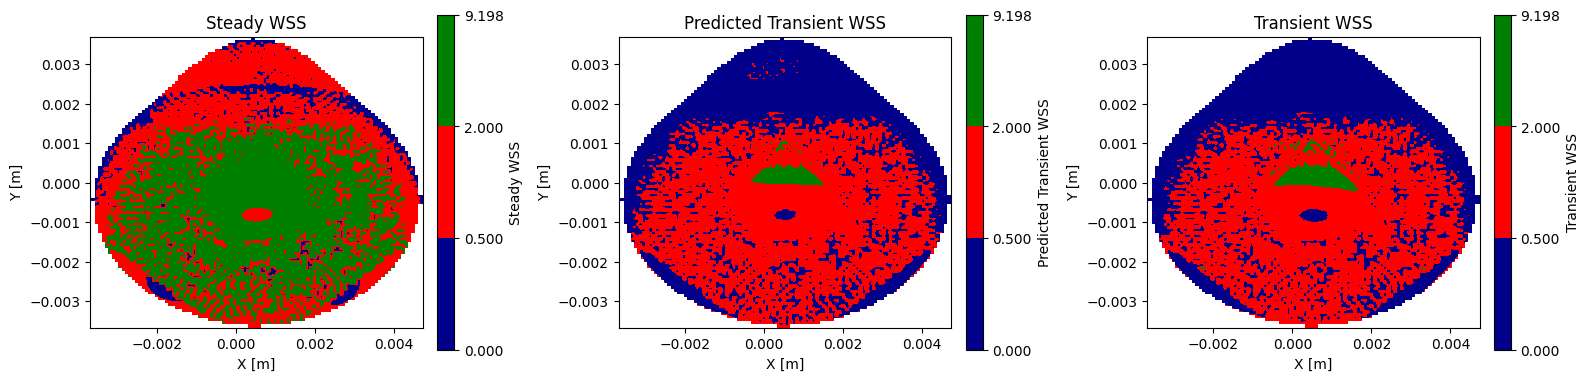

In [26]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste2, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel2, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste2, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

In [27]:
max_shear = np.max(Prediction2)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient2[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction2)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient2[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient2[' Wall Shear [ Pa ]'], Prediction2)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3/100, average_percentage_change4

Maximum shear from the prediction is: 2.3636248111724854
Maximum shear from the actual is: 2.75
Min shear from the prediction is: 0.053560588508844376
Min shear from the actual is: 0.00378
% is: 14.050006866455078
0.9856439083099277


(0.09055487399539042, 66.76899628740938)

# **RESULT N43**

In [28]:
PredictedTransient3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N43DS.csv')
# Print column names
print(PredictedTransient3.columns)
PredictedTransient3 = PredictedTransient3.fillna(0)
PredictedTransient3 = PredictedTransient3.replace(' null', np.nan)
x = PredictedTransient3[' X [ m ]']
y = PredictedTransient3[' Y [ m ]']
ste_velocity3 = PredictedTransient3[' Wall Shear [ Pa ]']
velocity3 = PredictedTransient3['Transient Prediction 3']
diff_ste3 = PredictedTransient3['Transient Prediction 3'] - PredictedTransient3[' Wall Shear [ Pa ]']
CFDTransient3 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N43Tlow\N43TS2.csv')
print(CFDTransient3.columns)
CFDTransient3 = CFDTransient3.fillna(0)
CFDTransient3 = CFDTransient3.replace(' null', np.nan)
x = CFDTransient3 [' X [ m ]']
y = CFDTransient3 [' Y [ m ]']
velocity_truth3 = CFDTransient3 [' Wall Shear [ Pa ]']
diff_vel3 = PredictedTransient3['Transient Prediction 3'] - CFDTransient3[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 3'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


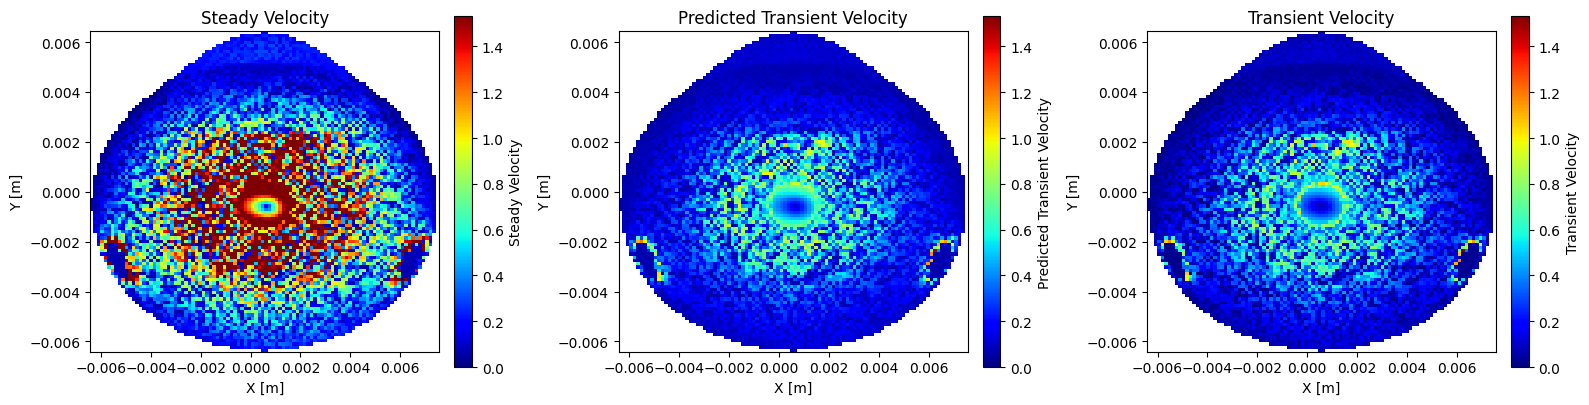

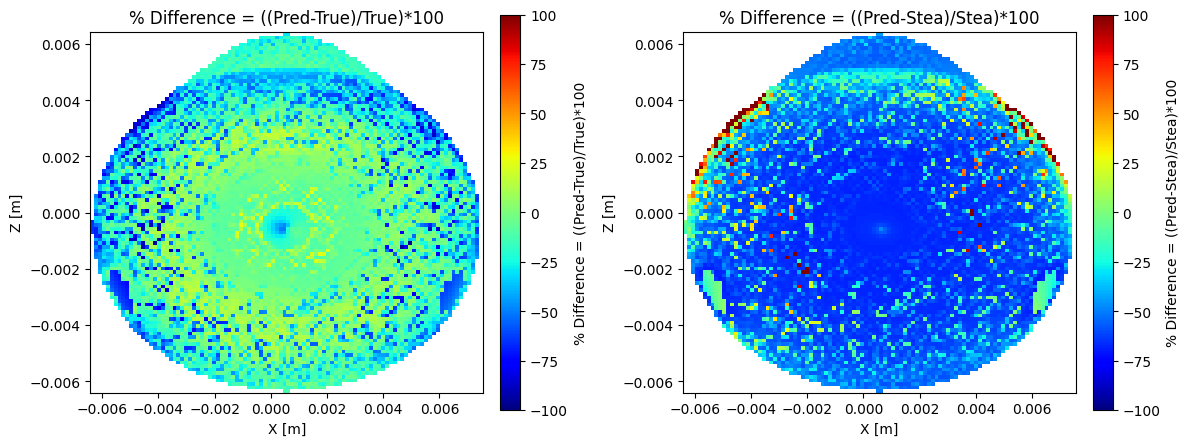

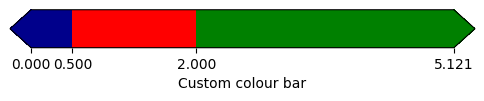

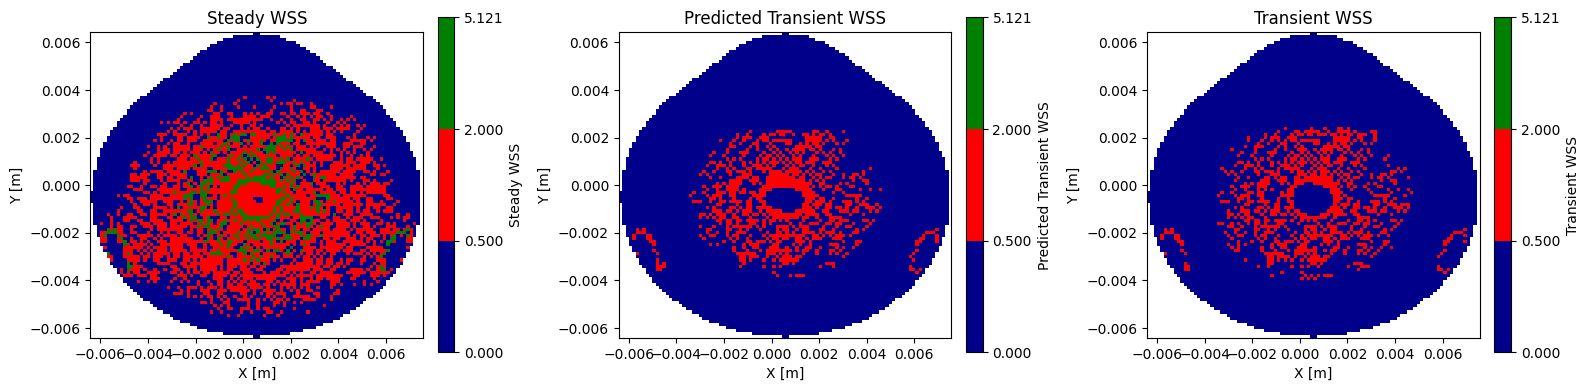

Maximum shear from the prediction is: 2.032100200653076
Maximum shear from the actual is: 2.12
Min shear from the prediction is: 0.04557142034173012
Min shear from the actual is: 0.0006
% is: 4.1462169503266
0.9712031502031423


(19.750688032524373, 54.40733969230374)

In [29]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste3, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel3, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste3, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction3)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient3[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction3)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient3[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient3[' Wall Shear [ Pa ]'], Prediction3)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N44**

In [30]:
PredictedTransient4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N44DS.csv')
# Print column names
print(PredictedTransient4.columns)
PredictedTransient4 = PredictedTransient4.fillna(0)
PredictedTransient4 = PredictedTransient4.replace(' null', np.nan)
x = PredictedTransient4[' X [ m ]']
y = PredictedTransient4[' Y [ m ]']
ste_velocity4 = PredictedTransient4[' Wall Shear [ Pa ]']
velocity4 = PredictedTransient4['Transient Prediction 4']
diff_ste4 = PredictedTransient4['Transient Prediction 4'] - PredictedTransient4[' Wall Shear [ Pa ]']
CFDTransient4 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N44Tlow\N44TS2.csv')
print(CFDTransient4.columns)
CFDTransient4 = CFDTransient4.fillna(0)
CFDTransient4 = CFDTransient4.replace(' null', np.nan)
x = CFDTransient4 [' X [ m ]']
y = CFDTransient4 [' Y [ m ]']
velocity_truth4 = CFDTransient4 [' Wall Shear [ Pa ]']
diff_vel4 = PredictedTransient4 ['Transient Prediction 4'] - CFDTransient4[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 4'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


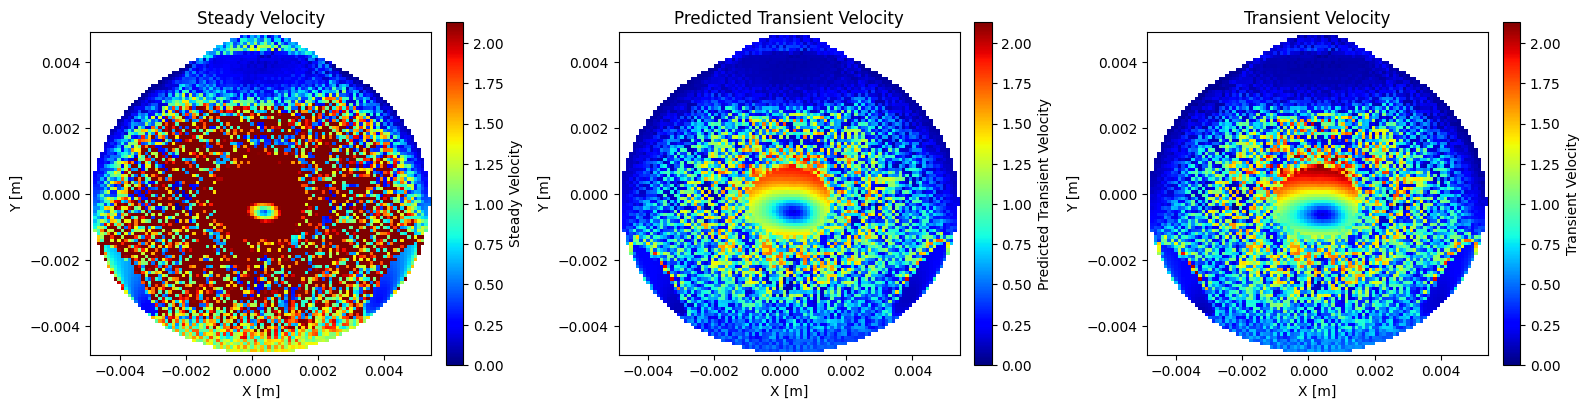

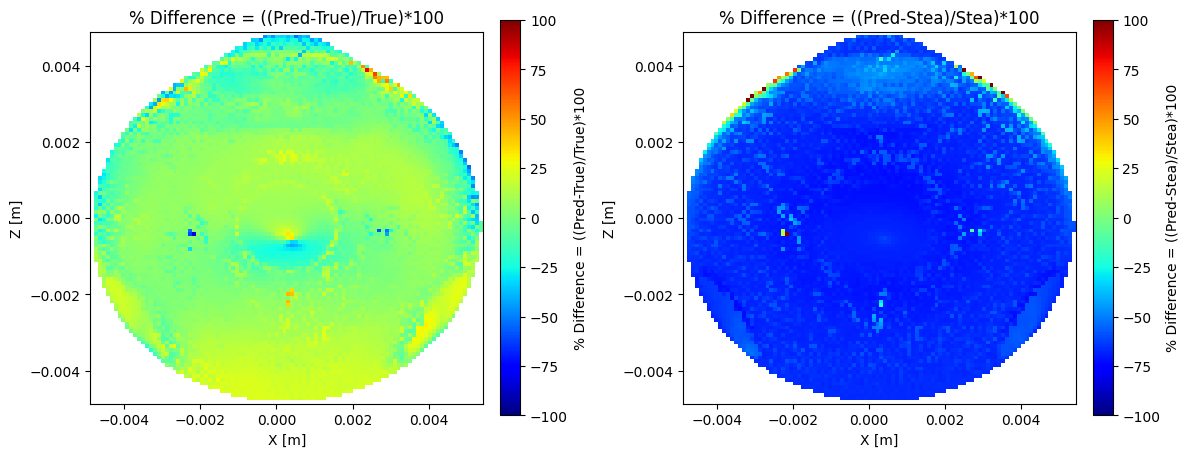

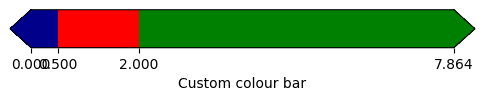

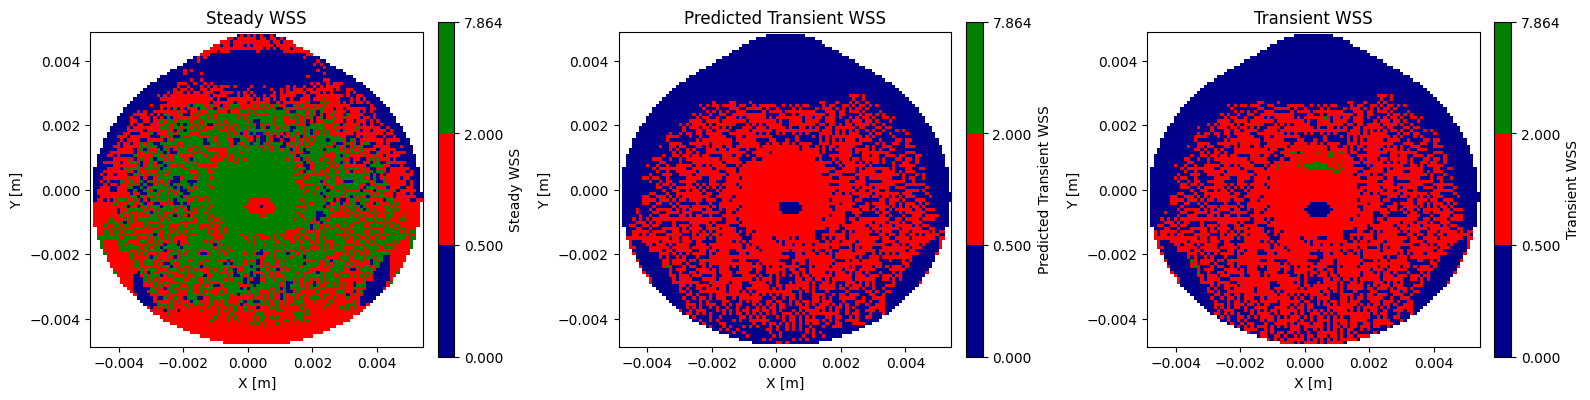

Maximum shear from the prediction is: 2.2602670192718506
Maximum shear from the actual is: 2.31
Min shear from the prediction is: 0.046203289180994034
Min shear from the actual is: 0.00778
% is: 2.1529428886644792
0.9837158495604048


(9.439582854321252, 64.60941814127432)

In [31]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste4, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel4, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste4, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction4)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient4[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction4)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient4[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient4[' Wall Shear [ Pa ]'], Prediction4)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N45**

In [32]:
PredictedTransient5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N45DS.csv')
# Print column names
print(PredictedTransient5.columns)
PredictedTransient5 = PredictedTransient5.fillna(0)
PredictedTransient5 = PredictedTransient5.replace(' null', np.nan)
x = PredictedTransient5[' X [ m ]']
y = PredictedTransient5[' Y [ m ]']
ste_velocity5 = PredictedTransient5[' Wall Shear [ Pa ]']
velocity5 = PredictedTransient5['Transient Prediction 5']
diff_ste5 = PredictedTransient5['Transient Prediction 5'] - PredictedTransient5[' Wall Shear [ Pa ]']
CFDTransient5 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N45Tlow\N45TS2.csv')
print(CFDTransient5.columns)
CFDTransient5 = CFDTransient5.fillna(0)
CFDTransient5 = CFDTransient5.replace(' null', np.nan)
x = CFDTransient5 [' X [ m ]']
y = CFDTransient5 [' Y [ m ]']
velocity_truth5 = CFDTransient5 [' Wall Shear [ Pa ]']
diff_vel5 = PredictedTransient5 ['Transient Prediction 5'] - CFDTransient5[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 5'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


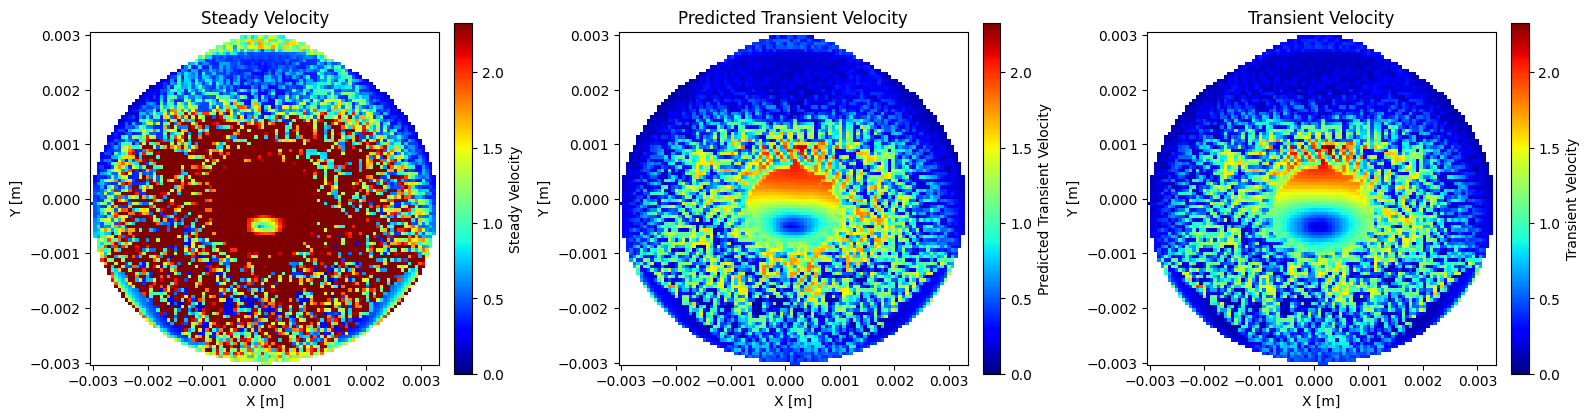

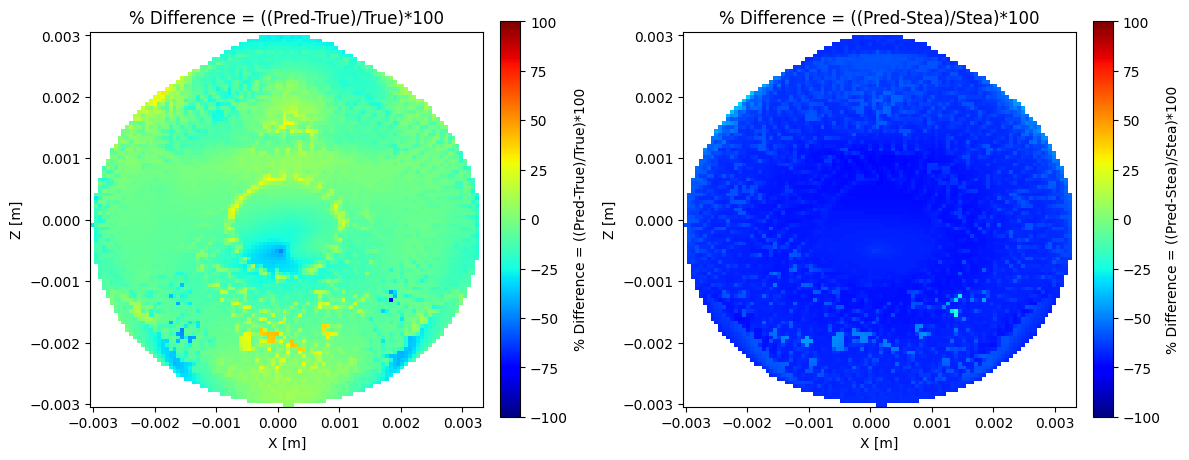

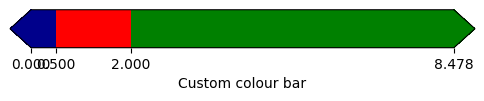

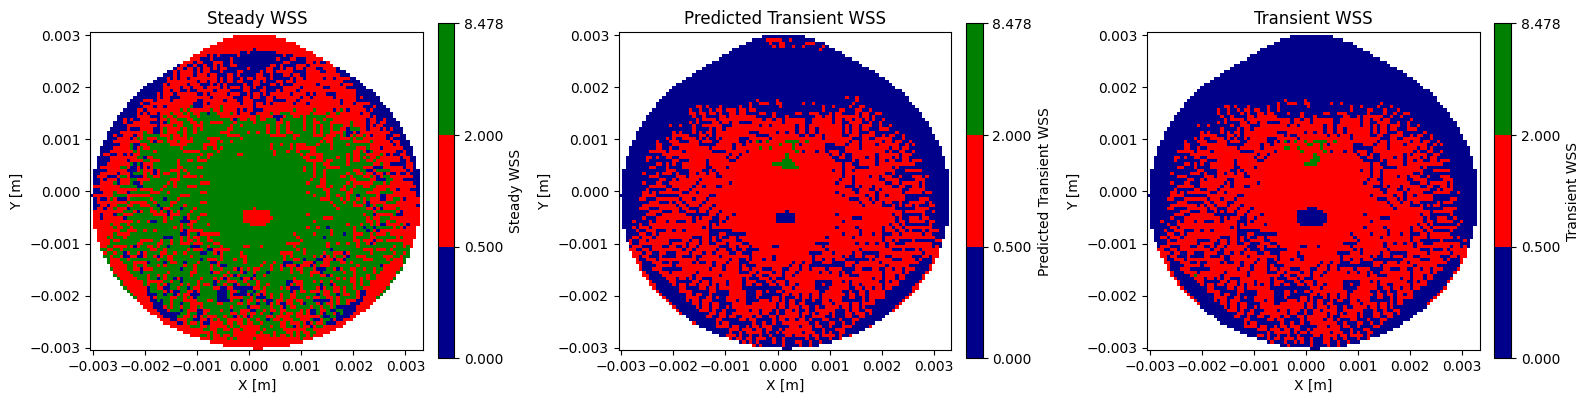

Maximum shear from the prediction is: 2.215413808822632
Maximum shear from the actual is: 2.38
Min shear from the prediction is: 0.053285811096429825
Min shear from the actual is: 0.00757
% is: 6.915386183923028
0.9760693589475877


(9.54384933776727, 66.3766139637098)

In [33]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste5, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel5, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste5, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction5)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient5[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction5)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient5[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient5[' Wall Shear [ Pa ]'], Prediction5)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N46**

In [34]:
PredictedTransient6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N46DS.csv')
# Print column names
print(PredictedTransient6.columns)
PredictedTransient6 = PredictedTransient6.fillna(0)
PredictedTransient6 = PredictedTransient6.replace(' null', np.nan)
x = PredictedTransient6[' X [ m ]']
y = PredictedTransient6[' Y [ m ]']
ste_velocity6 = PredictedTransient6[' Wall Shear [ Pa ]']
velocity6 = PredictedTransient6['Transient Prediction 6']
diff_ste6 = PredictedTransient6['Transient Prediction 6'] - PredictedTransient6[' Wall Shear [ Pa ]']
CFDTransient6 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N46Tlow\N46TS2.csv')
print(CFDTransient6.columns)
CFDTransient6 = CFDTransient6.fillna(0)
CFDTransient6 = CFDTransient6.replace(' null', np.nan)
x = CFDTransient6 [' X [ m ]']
y = CFDTransient6 [' Y [ m ]']
velocity_truth6 = CFDTransient6 [' Wall Shear [ Pa ]']
diff_vel6 = PredictedTransient6 ['Transient Prediction 6'] - CFDTransient6[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 6'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


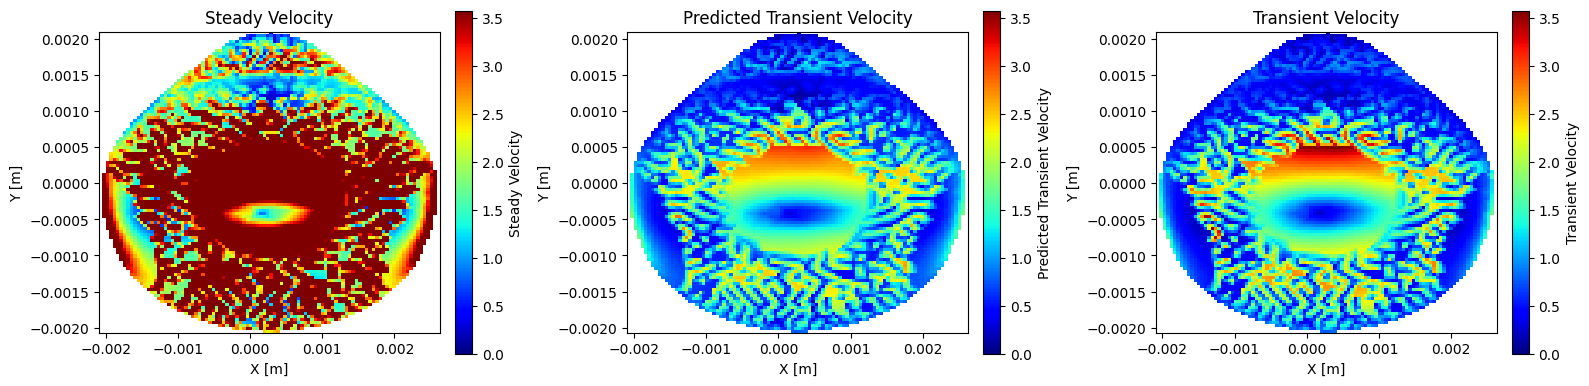

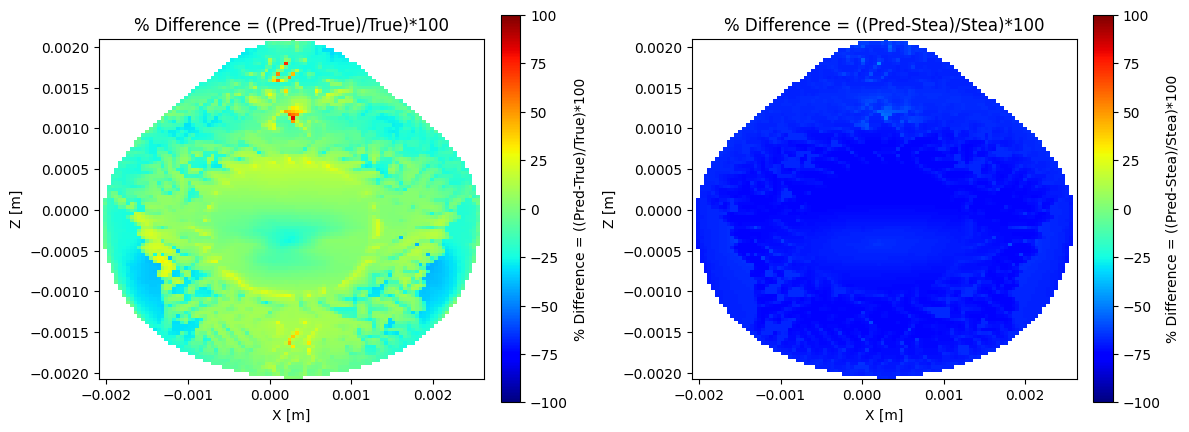

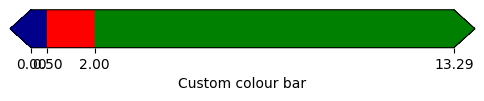

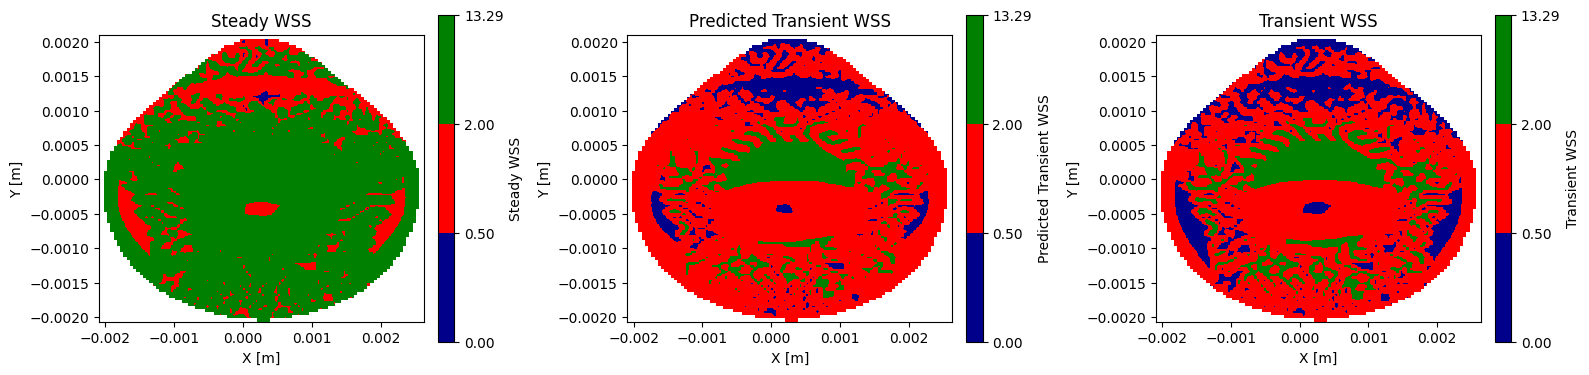

Maximum shear from the prediction is: 3.337754964828491
Maximum shear from the actual is: 4.0
Min shear from the prediction is: 0.05114290490746498
Min shear from the actual is: 0.0211
% is: 16.55612587928772
0.9662616870012637


(11.231337419696256, 70.68577430449099)

In [35]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste6, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel6, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste6, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction6)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient6[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction6)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient6[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient6[' Wall Shear [ Pa ]'], Prediction6)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N47**

In [36]:
PredictedTransient7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N47DS.csv')
# Print column names
print(PredictedTransient7.columns)
PredictedTransient7 = PredictedTransient7.fillna(0)
PredictedTransient7 = PredictedTransient7.replace(' null', np.nan)
x = PredictedTransient7[' X [ m ]']
y = PredictedTransient7[' Y [ m ]']
ste_velocity7 = PredictedTransient7[' Wall Shear [ Pa ]']
velocity7 = PredictedTransient7['Transient Prediction 7']
diff_ste7 = PredictedTransient7['Transient Prediction 7'] - PredictedTransient7[' Wall Shear [ Pa ]']
CFDTransient7 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N47Tlow\N47TS2.csv')
print(CFDTransient7.columns)
CFDTransient7 = CFDTransient7.fillna(0)
CFDTransient7 = CFDTransient7.replace(' null', np.nan)
x = CFDTransient7 [' X [ m ]']
y = CFDTransient7 [' Y [ m ]']
velocity_truth7 = CFDTransient7 [' Wall Shear [ Pa ]']
diff_vel7 = PredictedTransient7 ['Transient Prediction 7'] - CFDTransient7[' Wall Shear [ Pa ]']


Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 7'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


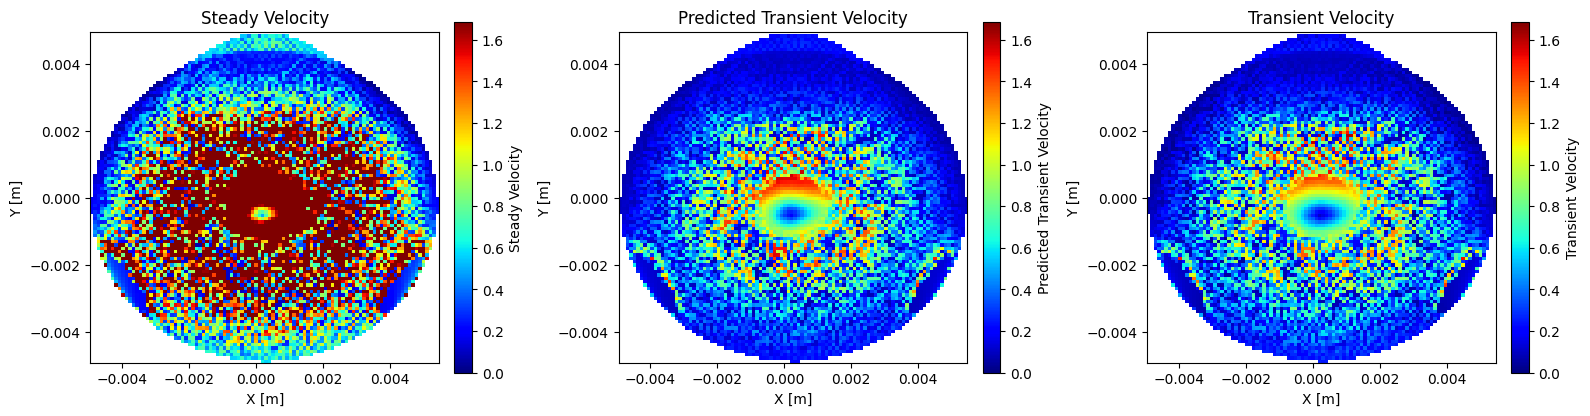

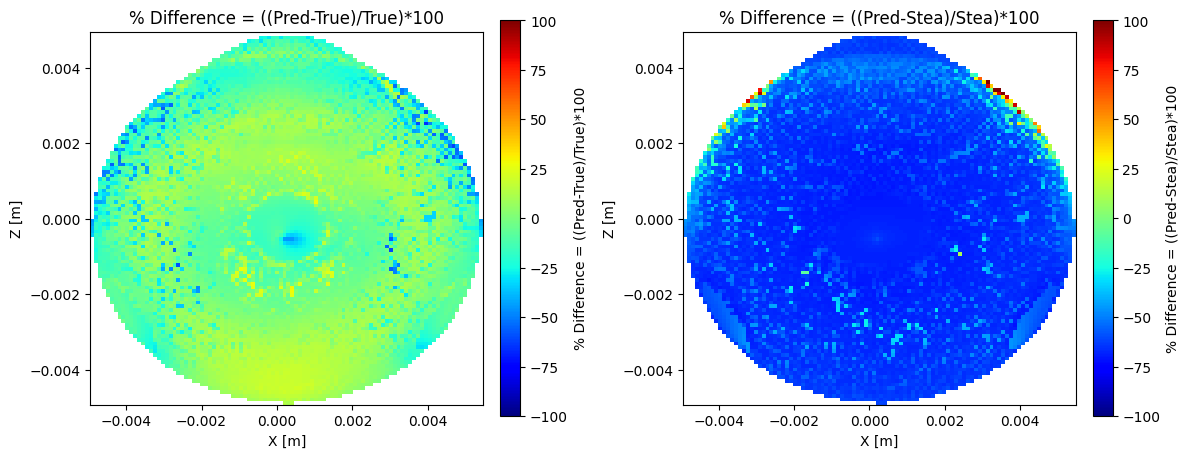

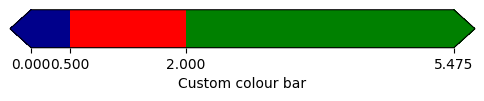

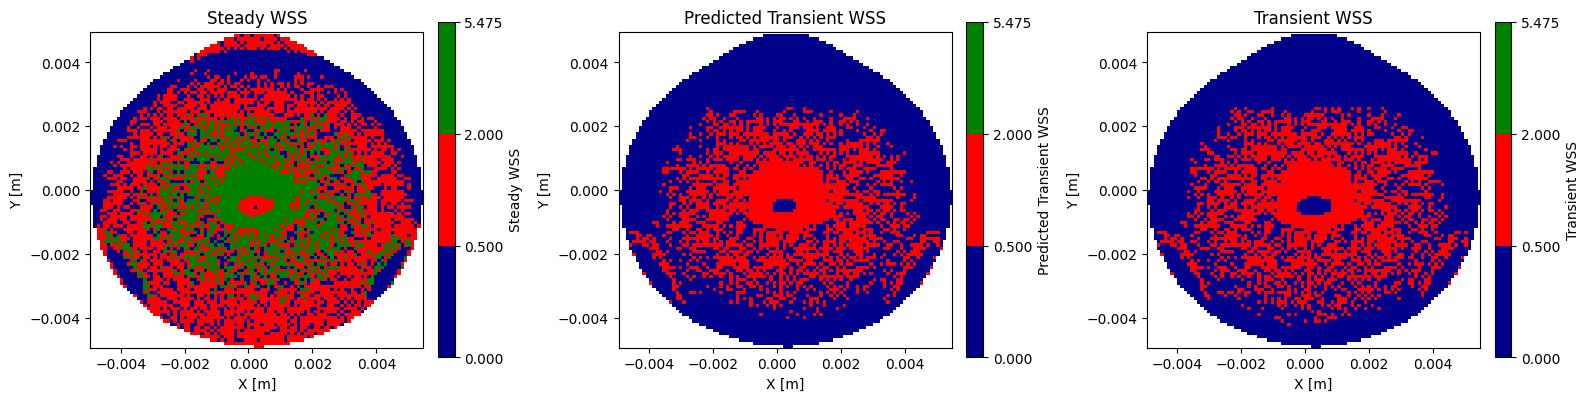

Maximum shear from the prediction is: 1.7961326837539673
Maximum shear from the actual is: 1.9
Min shear from the prediction is: 0.04528382793068886
Min shear from the actual is: 0.000913
% is: 5.4667008550543486
0.9835978757439637


(10.226050431537978, 61.927940149712555)

In [37]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste7, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel7, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste7, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction7)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient7[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction7)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient7[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient7[' Wall Shear [ Pa ]'], Prediction7)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N48**

In [38]:
PredictedTransient8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N48DS.csv')
# Print column names
print(PredictedTransient8.columns)
PredictedTransient8 = PredictedTransient8.fillna(0)
PredictedTransient8 = PredictedTransient8.replace(' null', np.nan)
x = PredictedTransient8[' X [ m ]']
y = PredictedTransient8[' Y [ m ]']
ste_velocity8 = PredictedTransient8[' Wall Shear [ Pa ]']
velocity8 = PredictedTransient8['Transient Prediction 8']
diff_ste8 = PredictedTransient8['Transient Prediction 8'] - PredictedTransient8[' Wall Shear [ Pa ]']
CFDTransient8 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N48Tlow\N48TS2.csv')
print(CFDTransient8.columns)
CFDTransient8 = CFDTransient8.fillna(0)
CFDTransient8 = CFDTransient8.replace(' null', np.nan)
x = CFDTransient8 [' X [ m ]']
y = CFDTransient8 [' Y [ m ]']
velocity_truth8 = CFDTransient8 [' Wall Shear [ Pa ]']
diff_vel8 = PredictedTransient8 ['Transient Prediction 8'] - CFDTransient8[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 8'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


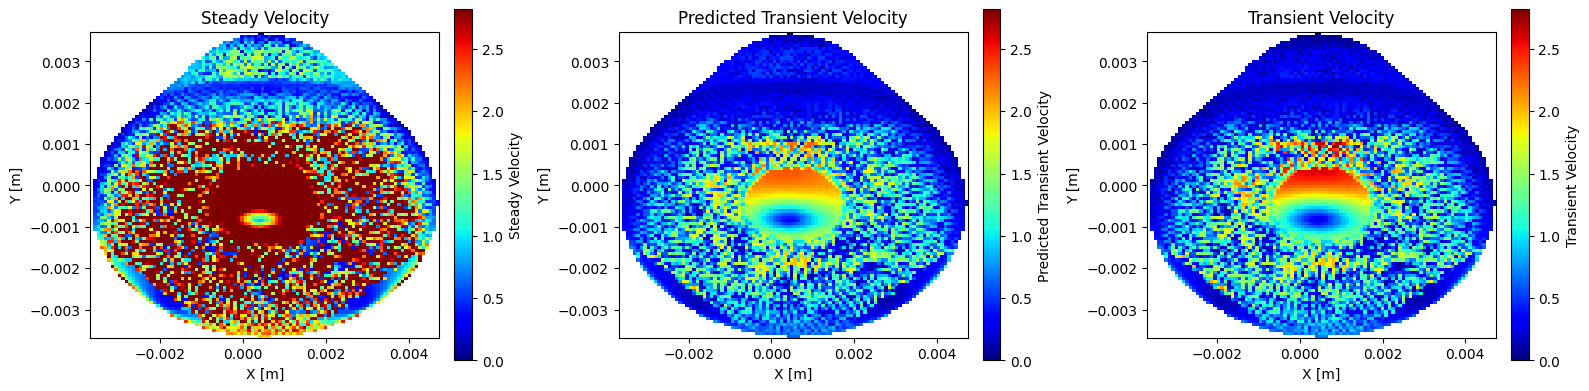

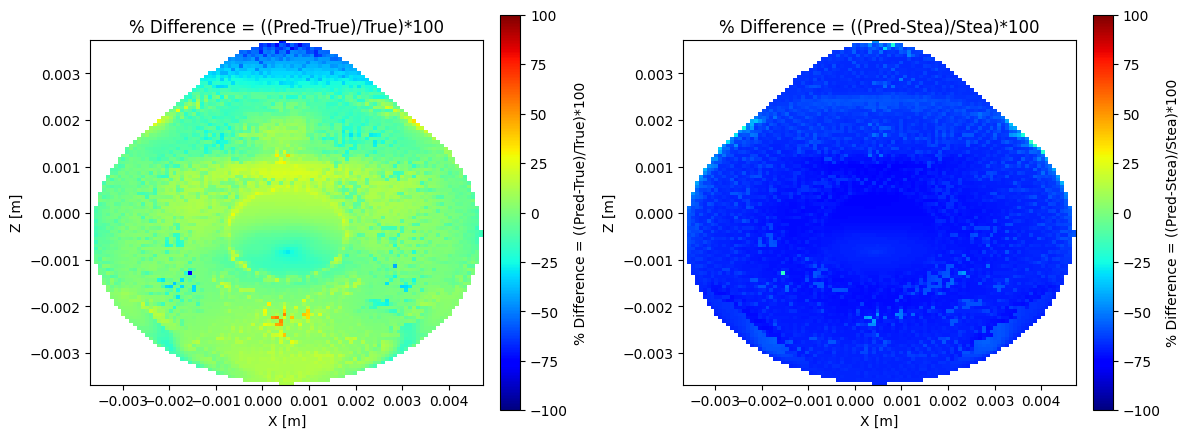

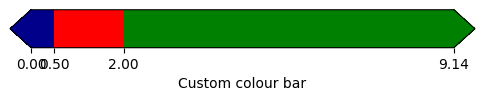

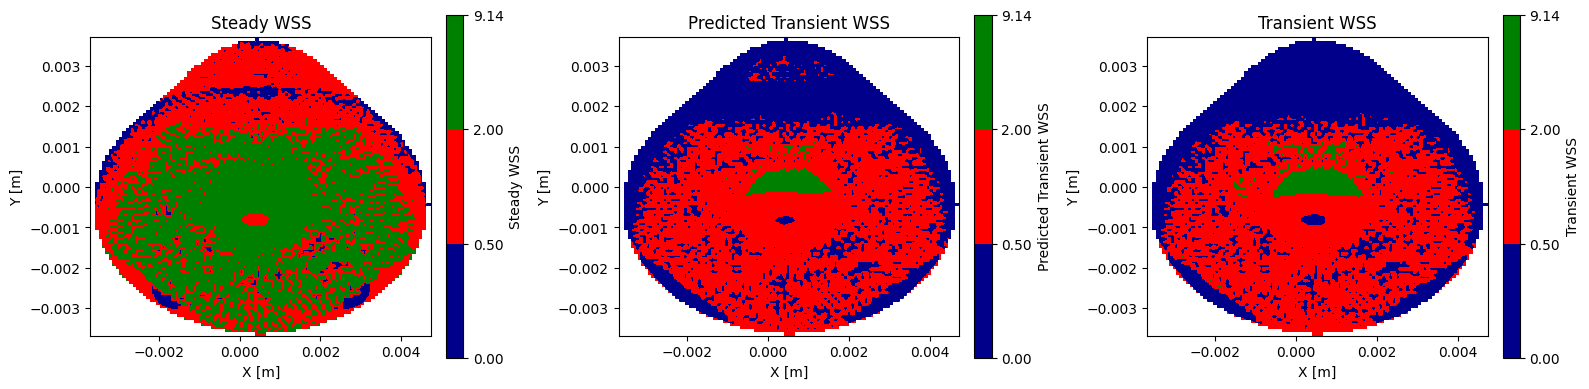

Maximum shear from the prediction is: 2.3616747856140137
Maximum shear from the actual is: 2.85
Min shear from the prediction is: 0.04891762509942055
Min shear from the actual is: 0.00368
% is: 17.1342180486311
0.9841328948330275


(8.927751167186315, 67.0934691070249)

In [39]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste8, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel8, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste8, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction8)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient8[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction8)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient8[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient8[' Wall Shear [ Pa ]'], Prediction8)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4

# **RESULT N49**

In [40]:
PredictedTransient9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\PredictionFile\N49DS.csv')
# Print column names
print(PredictedTransient9.columns)
PredictedTransient9 = PredictedTransient9.fillna(0)
PredictedTransient9 = PredictedTransient9.replace(' null', np.nan)
x = PredictedTransient9[' X [ m ]']
y = PredictedTransient9[' Y [ m ]']
ste_velocity9 = PredictedTransient9[' Wall Shear [ Pa ]']
velocity9 = PredictedTransient9['Transient Prediction 9']
diff_ste9 = PredictedTransient9['Transient Prediction 9'] - PredictedTransient9[' Wall Shear [ Pa ]']
CFDTransient9 = pd.read_csv(r'C:\Users\ismai\OneDrive\Desktop\CFD Dissertation\Files\CSV training\Predictions\N49Tlow\N49TS2.csv')
print(CFDTransient9.columns)
CFDTransient9 = CFDTransient9.fillna(0)
CFDTransient9 = CFDTransient9.replace(' null', np.nan)
x = CFDTransient9 [' X [ m ]']
y = CFDTransient9 [' Y [ m ]']
velocity_truth9 = CFDTransient9 [' Wall Shear [ Pa ]']
diff_vel9 = PredictedTransient9 ['Transient Prediction 9'] - CFDTransient9[' Wall Shear [ Pa ]']

Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]', ' Wall Shear [ Pa ]',
       'Transient Prediction 9'],
      dtype='object')
Index(['Node Number', ' X [ m ]', ' Y [ m ]', ' Z [ m ]',
       ' Wall Shear [ Pa ]'],
      dtype='object')


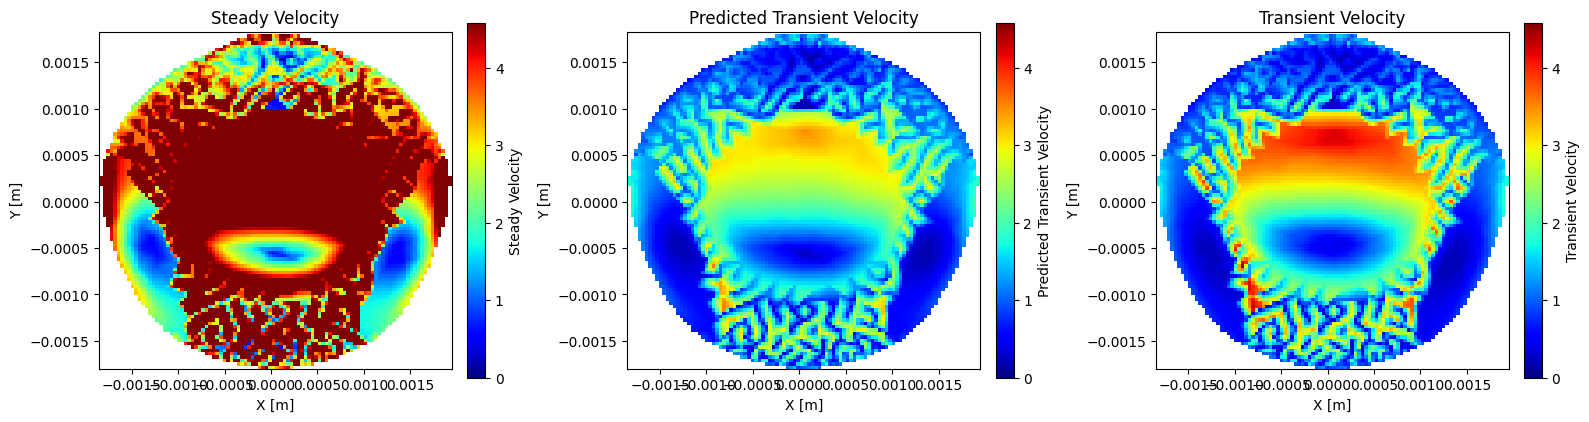

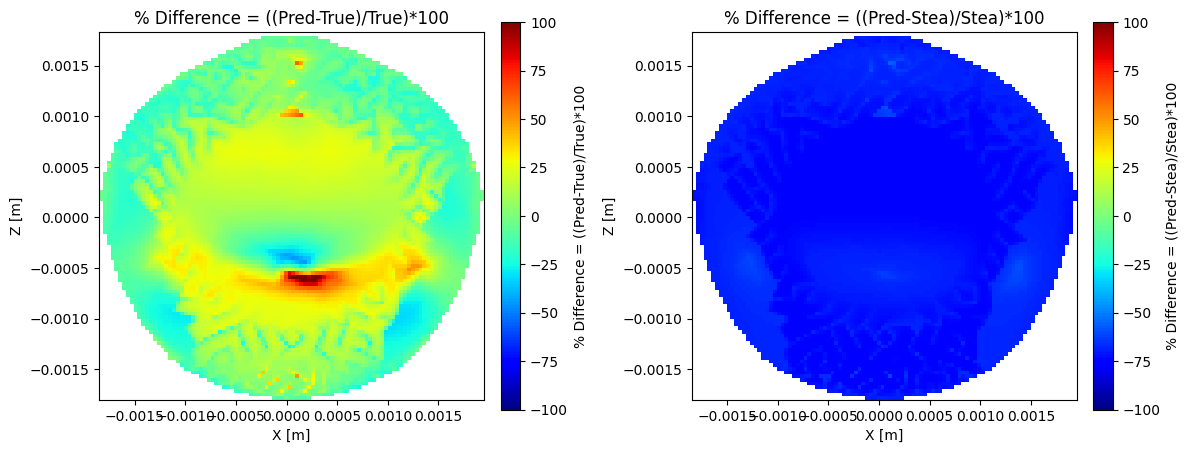

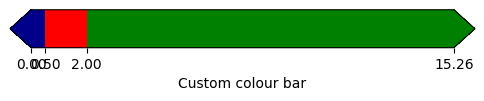

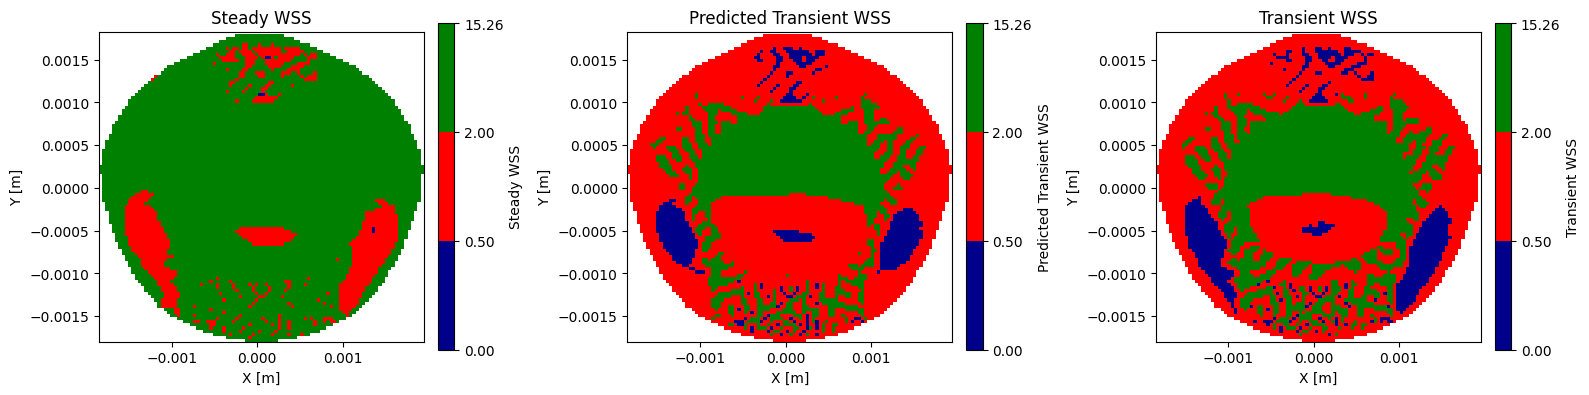

Maximum shear from the prediction is: 3.687659740447998
Maximum shear from the actual is: 4.82
Min shear from the prediction is: 0.08144566416740417
Min shear from the actual is: 0.18
% is: 23.492536505228262
0.9285179860542541


(15.366130246812538, 71.50549514738533)

In [41]:
# Generate grid
grid_x, grid_y = np.mgrid[min(x):max(x):100j, min(y):max(y):100j]

# Interpolation for velocity
grid_velocity0 = griddata((x, y), ste_velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity1 = griddata((x, y), velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity2 = griddata((x, y), velocity_truth9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity3 = griddata((x, y), diff_vel9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_velocity4 = griddata((x, y), diff_ste9, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping
cmap = plt.cm.jet  
cmap.set_bad(color='white')

# Masking operations
masked_velocity0 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity0), grid_velocity0)
masked_velocity1 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity1), grid_velocity1)
masked_velocity2 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity2), grid_velocity2)
masked_velocity3 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity3), grid_velocity3)
masked_velocity4 = ma.masked_where((grid_velocity0 <= 0.001) | np.isnan(grid_velocity4), grid_velocity4)

# Rotate the masked velocities
rotated_masked_velocity0 = np.rot90(masked_velocity0, 1)
rotated_masked_velocity1 = np.rot90(masked_velocity1, 1)
rotated_masked_velocity2 = np.rot90(masked_velocity2, 1)

# Plot velocities
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_velocity0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im0, ax=ax0, label='Steady Velocity',fraction=0.046, pad=0.04)
ax0.set_title('Steady Velocity')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_velocity1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im1, ax=ax1, label='Predicted Transient Velocity',fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient Velocity')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_velocity2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, vmin=0, vmax=rotated_masked_velocity2.max())
fig.colorbar(im2, ax=ax2, label='Transient Velocity',fraction=0.046, pad=0.04)
ax2.set_title('Transient Velocity')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()

# Calculate % differences
percentage_change3 = ((rotated_masked_velocity2 - rotated_masked_velocity1) / rotated_masked_velocity1) * 100
percentage_change4 = ((rotated_masked_velocity1 - rotated_masked_velocity0) / rotated_masked_velocity0) * 100

# Plot % differences
fig, (ax3, ax4) = plt.subplots(1, 2, figsize=(12, 12))
fig.patch.set_facecolor('white')

im3 = ax3.imshow(percentage_change3.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im3, ax=ax3, label='% Difference = ((Pred-True)/True)*100', fraction=0.046, pad=0.04)
ax3.set_title('% Difference = ((Pred-True)/True)*100')
ax3.set_xlabel("X [m]")
ax3.set_ylabel("Z [m]")

im4 = ax4.imshow(percentage_change4.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap='jet', vmin=-100, vmax=100)
fig.colorbar(im4, ax=ax4, label='% Difference = ((Pred-Stea)/Stea)*100', fraction=0.046, pad=0.04)
ax4.set_title('% Difference = ((Pred-Stea)/Stea)*100')
ax4.set_xlabel("X [m]")
ax4.set_ylabel("Z [m]")

plt.tight_layout()
plt.show()
grid_WSS0 = griddata((x, y), ste_velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS1 = griddata((x, y), velocity9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS2 = griddata((x, y), velocity_truth9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS3 = griddata((x, y), diff_vel9, (grid_x, grid_y), method='linear', fill_value=np.nan)
grid_WSS4 = griddata((x, y), diff_ste9, (grid_x, grid_y), method='linear', fill_value=np.nan)

# Color mapping setup
max_value = np.nanmax([grid_WSS0])
colours = ['darkblue', 'red', 'green']
bins = [0, 0.5, 2, max_value]
assert len(bins) == len(colours) + 1

cmap = mpl.colors.ListedColormap(colours)
norm = mpl.colors.BoundaryNorm(boundaries=bins, ncolors=len(cmap.colors))

fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cb2 = mpl.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                boundaries=bins,
                                extend='both',
                                ticks=bins,
                                spacing='proportional',
                                orientation='horizontal')
cb2.set_label('Custom colour bar')
plt.show()

cmap.set_bad(color='white')

# Masking operations
masked_WSS0 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS0), grid_WSS0)
masked_WSS1 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS1), grid_WSS1)
masked_WSS2 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS2), grid_WSS2)
masked_WSS3 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS3), grid_WSS3)
masked_WSS4 = ma.masked_where((grid_WSS0 <= 0.0001) | np.isnan(grid_WSS4), grid_WSS4)

# Rotate the masked WSS
rotated_masked_WSS0 = np.rot90(masked_WSS0, 1)
rotated_masked_WSS1 = np.rot90(masked_WSS1, 1)
rotated_masked_WSS2 = np.rot90(masked_WSS2, 1)

# Plot WSS
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(16, 26))
fig.patch.set_facecolor('white')

im0 = ax0.imshow(rotated_masked_WSS0.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im0, ax=ax0, label='Steady WSS', fraction=0.046, pad=0.04)
ax0.set_title('Steady WSS')
ax0.set_xlabel("X [m]")
ax0.set_ylabel("Y [m]")

im1 = ax1.imshow(rotated_masked_WSS1.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im1, ax=ax1, label='Predicted Transient WSS', fraction=0.046, pad=0.04)
ax1.set_title('Predicted Transient WSS')
ax1.set_xlabel("X [m]")
ax1.set_ylabel("Y [m]")

im2 = ax2.imshow(rotated_masked_WSS2.T, extent=(min(x), max(x), min(y), max(y)), origin='lower', cmap=cmap, norm=norm)
fig.colorbar(im2, ax=ax2, label='Transient WSS', fraction=0.046, pad=0.04)
ax2.set_title('Transient WSS')
ax2.set_xlabel("X [m]")
ax2.set_ylabel("Y [m]")

plt.tight_layout()
plt.show()


max_shear = np.max(Prediction9)
print(f"Maximum shear from the prediction is: {max_shear}")
max_shear2 = CFDTransient9[' Wall Shear [ Pa ]'].max()
print(f"Maximum shear from the actual is: {max_shear2}")

min_shear = np.min(Prediction9)
print(f"Min shear from the prediction is: {min_shear}")
min_shear2 = CFDTransient9[' Wall Shear [ Pa ]'].min()
print(f"Min shear from the actual is: {min_shear2}")

relative_error = abs(max_shear - max_shear2) / abs(max_shear2)
relative_error_percentage = relative_error * 100  # Convert to percentage

print(f'% is: {relative_error_percentage}')
from sklearn.metrics import r2_score
r2 = r2_score( CFDTransient9[' Wall Shear [ Pa ]'], Prediction9)
print(r2)
average_percentage_change3 = np.mean(np.abs(percentage_change3))
average_percentage_change4 = np.mean(np.abs(percentage_change4))

average_percentage_change3, average_percentage_change4